In [1]:
import os
import sys
sys.path.append(os.chdir('../../'))

In [2]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import datetime

import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
import src.utils.graph as graph
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

tqdm.pandas()
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1

In [3]:
import src.data as data
import src.utility as utility

In [4]:
mode = 'train'
steps_behind_event=4
steps_after_event=3

In [33]:
#sensors = data.sensors()
s = data.speeds_original(mode) #.merge(sensors, how='left')
# - events
e = data.events(mode)
# - weather
# ......

# join dataframes
joined_df = utility.merge_speed_events(s, e)

In [6]:
joined_df.head()

event_index  KEY        DATETIME_UTC   KM   SPEED_AVG   SPEED_SD  \
0 NaN           0   2018-09-01 01:00:00  443  97.889000   1.144099    
1 NaN           0   2018-09-01 03:15:00  443  154.788667  16.287509   
2 NaN           0   2018-09-01 12:45:00  443  136.091778  10.759666   
3 NaN           0   2018-09-01 19:15:00  443  136.916276  15.089653   
4 NaN           0   2018-09-02 09:45:00  443  135.476385  23.125778   

   SPEED_MIN  SPEED_MAX  N_VEHICLES KEY_2 START_DATETIME_UTC END_DATETIME_UTC  \
0  97.080     98.698     2           NaN  NaT                NaT                
1  137.530    169.890    3           NaN  NaT                NaT                
2  124.586    163.418    18          NaN  NaT                NaT                
3  114.878    169.890    58          NaN  NaT                NaT                
4  82.518     169.890    26          NaN  NaT                NaT                

   EVENT_DETAIL EVENT_TYPE  KM_END  KM_START  KM_EVENT  step_duration  
0 NaN            NaN       NaN     NaN       NaN       NaN             
1 NaN            NaN       NaN     NaN       NaN       NaN             
2 NaN            NaN       NaN     NaN       NaN       NaN             
3 NaN            NaN       NaN     NaN       NaN       NaN             
4 NaN            NaN       NaN     NaN       NaN       NaN

In [35]:
joined_df[(joined_df['KEY']== 0.0)&(joined_df['KM']==337.0)&(joined_df['DATETIME_UTC']=='2018-09-05 18:00:00')]

event_index  KEY        DATETIME_UTC   KM   SPEED_AVG   SPEED_SD  \
6502581 NaN           0   2018-09-05 18:00:00  337  197.453376  52.792587   

         SPEED_MIN  SPEED_MAX  N_VEHICLES KEY_2 START_DATETIME_UTC  \
6502581  59.866     406.118    141         NaN  NaT                  

        END_DATETIME_UTC  EVENT_DETAIL EVENT_TYPE  KM_END  KM_START  KM_EVENT  \
6502581 NaT              NaN            NaN       NaN     NaN       NaN         

         step_duration  
6502581 NaN

In [30]:
joined_df.head()

event_index  KEY        DATETIME_UTC   KM   SPEED_AVG   SPEED_SD  \
0 NaN           0   2018-09-01 01:00:00  443  97.889000   1.144099    
1 NaN           0   2018-09-01 03:15:00  443  154.788667  16.287509   
2 NaN           0   2018-09-01 12:45:00  443  136.091778  10.759666   
3 NaN           0   2018-09-01 19:15:00  443  136.916276  15.089653   
4 NaN           0   2018-09-02 09:45:00  443  135.476385  23.125778   

   SPEED_MIN  SPEED_MAX  N_VEHICLES KEY_2  EMERGENCY_LANE  LANES  ROAD_TYPE  \
0  97.080     98.698     2           NaN   1               2      1           
1  137.530    169.890    3           NaN   1               2      1           
2  124.586    163.418    18          NaN   1               2      1           
3  114.878    169.890    58          NaN   1               2      1           
4  82.518     169.890    26          NaN   1               2      1           

  START_DATETIME_UTC END_DATETIME_UTC  EVENT_DETAIL EVENT_TYPE  KM_END  \
0 NaT                NaT              NaN            NaN       NaN       
1 NaT                NaT              NaN            NaN       NaN       
2 NaT                NaT              NaN            NaN       NaN       
3 NaT                NaT              NaN            NaN       NaN       
4 NaT                NaT              NaN            NaN       NaN       

   KM_START  KM_EVENT  step_duration  
0 NaN       NaN       NaN             
1 NaN       NaN       NaN             
2 NaN       NaN       NaN             
3 NaN       NaN       NaN             
4 NaN       NaN       NaN

In [36]:
def time_windows_event(dataset_df, steps_behind=10, steps_after=3, step=15*60):
    """ Filter the dataset to get a window containing n time steps before the beginning
        of the event and m time steps after the end for each involved sensor

        dataset_df (df): dataset dataframe
        steps_behind (int): n (not including the event start)
        steps_after (int): m (not including the event start)
    """
    tqdm.pandas()
    # get the first time step of each event for each sensor
    start_events = dataset_df[dataset_df.event_index.notnull()]
    start_events = start_events[['KEY_2','event_index','DATETIME_UTC']].groupby(['KEY_2','event_index']).min()
    start_events = start_events.reset_index()[['KEY_2','DATETIME_UTC','event_index']]
    start_events['sample_id'] = start_events.index
    print('Total events found:', start_events.shape[0])

    start_delta = datetime.timedelta(seconds=step*steps_behind)
    end_delta = datetime.timedelta(seconds=step*steps_after)

    # construct the time window for each event beginning
    start_events['window'] = start_events.progress_apply(lambda x:
                                    list(pd.date_range(start=x.DATETIME_UTC - start_delta,
                                                       end=x.DATETIME_UTC + end_delta,
                                                       freq=f'{step}s')), axis=1)
    start_events = start_events.drop('DATETIME_UTC', axis=1)

    # build the filter
    filter_df = pd.DataFrame({ col: np.repeat(start_events[col].values, start_events['window'].str.len())
        for col in start_events.columns.drop('window')
    }).assign(**{'DATETIME_UTC': np.concatenate(start_events['window'].values)})
    print('Filter size:', filter_df.shape[0])
    return filter_df

    # join to filter the desired rows, removing duplicated road-timestamps from the dataset (they will be duplicated again
    # after the merge, since a different time window is created for each event)
    return dataset_df.drop('event_index', axis=1) \
            .merge(filter_df, how='right', on=['KEY_2','DATETIME_UTC']) \
            .sort_values(['sample_id','DATETIME_UTC'])
#.drop_duplicates(['KEY_2','DATETIME_UTC'])

In [37]:
filter_df = time_windows_event(joined_df, steps_behind=steps_behind_event, steps_after=steps_after_event)

Total events found: 34083



Filter size: 272664


In [44]:
filter_df[(filter_df['KEY_2']== '0_337')&(filter_df['DATETIME_UTC']=='2018-09-05 18:00:00')]

KEY_2  event_index  sample_id        DATETIME_UTC
0    0_337  2674.0       0         2018-09-05 18:00:00
67   0_337  545413.0     8         2018-09-05 18:00:00
73   0_337  545414.0     9         2018-09-05 18:00:00
338  0_337  4878128.0    42        2018-09-05 18:00:00

In [38]:
filter_df.head()

KEY_2  event_index  sample_id        DATETIME_UTC
0  0_337  2674.0       0         2018-09-05 18:00:00
1  0_337  2674.0       0         2018-09-05 18:15:00
2  0_337  2674.0       0         2018-09-05 18:30:00
3  0_337  2674.0       0         2018-09-05 18:45:00
4  0_337  2674.0       0         2018-09-05 19:00:00

In [40]:
joined_df.drop('event_index', axis=1).merge(filter_df, how='right', on=['KEY_2','DATETIME_UTC'])

KEY        DATETIME_UTC     KM   SPEED_AVG   SPEED_SD  SPEED_MIN  \
0       0.0 2018-10-16 12:45:00  454.0  215.255834  45.061795  63.102      
1       0.0 2018-10-16 12:45:00  454.0  215.255834  45.061795  63.102      
2       0.0 2018-10-16 12:45:00  454.0  215.255834  45.061795  63.102      
3       0.0 2018-10-16 12:45:00  454.0  215.255834  45.061795  63.102      
4       0.0 2018-10-16 12:45:00  454.0  215.255834  45.061795  63.102      
5       0.0 2018-10-16 14:15:00  454.0  226.829172  44.187549  129.440     
6       0.0 2018-10-16 14:15:00  454.0  226.829172  44.187549  129.440     
7       0.0 2018-10-16 14:15:00  454.0  226.829172  44.187549  129.440     
8       0.0 2018-10-16 14:15:00  454.0  226.829172  44.187549  129.440     
9       0.0 2018-10-16 14:15:00  454.0  226.829172  44.187549  129.440     
10      0.0 2018-10-16 14:15:00  454.0  226.829172  44.187549  129.440     
11      0.0 2018-10-16 14:15:00  454.0  226.829172  44.187549  129.440     
12      0.0 2018-11-15 11:45:00  454.0  225.069379  42.788778  74.428      
13      0.0 2018-11-15 11:45:00  454.0  225.069379  42.788778  74.428      
14      0.0 2018-11-15 11:45:00  454.0  225.069379  42.788778  74.428      
15      0.0 2018-11-15 11:45:00  454.0  225.069379  42.788778  74.428      
16      0.0 2018-11-15 11:45:00  454.0  225.069379  42.788778  74.428      
17      0.0 2018-11-15 11:45:00  454.0  225.069379  42.788778  74.428      
18      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
19      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
20      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
21      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
22      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
23      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
24      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
25      0.0 2018-11-15 12:15:00  454.0  225.654228  45.892951  135.912     
26      0.0 2018-11-15 12:30:00  454.0  227.612150  44.424384  129.440     
27      0.0 2018-11-15 12:30:00  454.0  227.612150  44.424384  129.440     
28      0.0 2018-11-15 12:30:00  454.0  227.612150  44.424384  129.440     
29      0.0 2018-11-15 12:30:00  454.0  227.612150  44.424384  129.440     
...     ...                 ...    ...         ...        ...      ...     
284661 NaN  2018-09-21 12:15:00 NaN    NaN         NaN        NaN          
284662 NaN  2018-09-21 12:15:00 NaN    NaN         NaN        NaN          
284663 NaN  2018-09-21 12:30:00 NaN    NaN         NaN        NaN          
284664 NaN  2018-09-21 12:30:00 NaN    NaN         NaN        NaN          
284665 NaN  2018-09-21 12:45:00 NaN    NaN         NaN        NaN          
284666 NaN  2018-09-21 06:30:00 NaN    NaN         NaN        NaN          
284667 NaN  2018-11-03 21:45:00 NaN    NaN         NaN        NaN          
284668 NaN  2018-11-03 21:45:00 NaN    NaN         NaN        NaN          
284669 NaN  2018-11-03 22:00:00 NaN    NaN         NaN        NaN          
284670 NaN  2018-11-03 22:00:00 NaN    NaN         NaN        NaN          
284671 NaN  2018-11-03 22:15:00 NaN    NaN         NaN        NaN          
284672 NaN  2018-11-03 22:15:00 NaN    NaN         NaN        NaN          
284673 NaN  2018-11-03 23:00:00 NaN    NaN         NaN        NaN          
284674 NaN  2018-11-03 23:00:00 NaN    NaN         NaN        NaN          
284675 NaN  2018-11-03 23:15:00 NaN    NaN         NaN        NaN          
284676 NaN  2018-11-03 23:15:00 NaN    NaN         NaN        NaN          
284677 NaN  2018-11-03 23:30:00 NaN    NaN         NaN        NaN          
284678 NaN  2018-11-04 07:30:00 NaN    NaN         NaN        NaN          
284679 NaN  2018-11-04 07:30:00 NaN    NaN         NaN        NaN          
284680 NaN  2018-11-04 07:45:00 NaN    NaN         NaN        NaN          
284681 NaN  2018-11-04 07:45:00 NaN    NaN         NaN  

In [18]:
joined_df = utility.time_windows_event(joined_df, steps_behind=steps_behind_event, steps_after=steps_after_event)

Total events found: 34083



Filter size: 272664


In [32]:
joined_df = time_windows_event(joined_df, steps_behind=steps_behind_event, steps_after=steps_after_event)

Total events found: 34083



Filter size: 272664


KeyError: 'sample_id'

In [33]:
joined_df.head(15)

KEY        DATETIME_UTC     KM   SPEED_AVG   SPEED_SD  SPEED_MIN  \
424129 NaN  2018-09-05 16:30:00 NaN    NaN         NaN        NaN          
424133 NaN  2018-09-05 16:45:00 NaN    NaN         NaN        NaN          
424137 NaN  2018-09-05 17:00:00 NaN    NaN         NaN        NaN          
424141 NaN  2018-09-05 17:15:00 NaN    NaN         NaN        NaN          
424145 NaN  2018-09-05 17:30:00 NaN    NaN         NaN        NaN          
424149 NaN  2018-09-05 17:45:00 NaN    NaN         NaN        NaN          
424153 NaN  2018-09-05 18:00:00 NaN    NaN         NaN        NaN          
22237   0.0 2018-09-05 18:15:00  337.0  199.664224  41.445704  59.866      
191189  0.0 2018-09-05 18:30:00  337.0  199.315023  52.064260  59.866      
22241   0.0 2018-09-05 18:45:00  337.0  204.775942  43.065888  59.866      
147     0.0 2018-09-05 19:00:00  337.0  201.772145  49.993015  59.866      
424157 NaN  2018-09-05 19:15:00 NaN    NaN         NaN        NaN          
424160 NaN  2018-09-05 19:30:00 NaN    NaN         NaN        NaN          
424162 NaN  2018-09-05 19:45:00 NaN    NaN         NaN        NaN          
424163 NaN  2018-09-20 14:00:00 NaN    NaN         NaN        NaN          

        SPEED_MAX  N_VEHICLES  KEY_2  EMERGENCY_LANE  LANES  ROAD_TYPE  \
424129 NaN        NaN          0_337 NaN             NaN    NaN          
424133 NaN        NaN          0_337 NaN             NaN    NaN          
424137 NaN        NaN          0_337 NaN             NaN    NaN          
424141 NaN        NaN          0_337 NaN             NaN    NaN          
424145 NaN        NaN          0_337 NaN             NaN    NaN          
424149 NaN        NaN          0_337 NaN             NaN    NaN          
424153 NaN        NaN          0_337 NaN             NaN    NaN          
22237   263.734    107.0       0_337  1.0             2.0    1.0         
191189  292.858    129.0       0_337  1.0             2.0    1.0         
22241   294.476    139.0       0_337  1.0             2.0    1.0         
147     312.274    193.0       0_337  1.0             2.0    1.0         
424157 NaN        NaN          0_337 NaN             NaN    NaN          
424160 NaN        NaN          0_337 NaN             NaN    NaN          
424162 NaN        NaN          0_337 NaN             NaN    NaN          
424163 NaN        NaN          0_337 NaN             NaN    NaN          

        START_DATETIME_UTC    END_DATETIME_UTC  EVENT_DETAIL  \
424129 NaT                 NaT                 NaN             
424133 NaT                 NaT                 NaN             
424137 NaT                 NaT                 NaN             
424141 NaT                 NaT                 NaN             
424145 NaT                 NaT                 NaN             
424149 NaT                 NaT                 NaN             
424153 NaT                 NaT                 NaN             
22237  2018-09-05 18:15:00 2018-09-05 19:00:00  11.0           
191189 2018-09-05 18:15:00 2018-09-05 19:00:00  11.0           
22241  2018-09-05 18:15:00 2018-09-05 19:00:00  11.0           
147    2018-09-05 18:15:00 2018-09-05 19:00:00  11.0           
424157 NaT                 NaT                 NaN             
424160 NaT                 NaT                 NaN             
424162 NaT                 NaT                 NaN             
424163 NaT                 NaT                 NaN             

               EVENT_TYPE  KM_END  KM_START  KM_EVENT  step_duration  \
424129  NaN               NaN     NaN       NaN       NaN              
424133  NaN               NaN     NaN       NaN       NaN              
424137  NaN               NaN     NaN       NaN       NaN              
424141  NaN               NaN     NaN       NaN       NaN              
424145  NaN               NaN     NaN       NaN       NaN              
424149  NaN               NaN     NaN       NaN       NaN              
424153  NaN               NaN     NaN       NaN       NaN              
22237

In [38]:
event_beginning_step = steps_behind_event+1
joined_df = joined_df.round(4).groupby('sample_id').agg({
    'KEY':'first',
    'KM':'first',
    'event_index':lambda x: x.values[steps_behind_event],
    'DATETIME_UTC':list,
    'SPEED_AVG':list, #[list, lambda x: x[0:event_beginning_step].dropna().mean()],
    'SPEED_SD':list,
    'SPEED_MAX':list,
    'SPEED_MIN':list,
    'N_VEHICLES':list,
    'EMERGENCY_LANE':'first',
    'LANES':'first',
    'ROAD_TYPE':'first',
    'EVENT_DETAIL':lambda x: x.values[steps_behind_event],
    'EVENT_TYPE':lambda x: x.values[steps_behind_event]
})

In [41]:
joined_df.head(15)
#joined_df[joined_df.EVENT_TYPE.isnull()]

KEY     KM  event_index  \
sample_id                            
0          0.0  337.0  2674.0        
1          0.0  337.0  2734.0        
2          0.0  337.0  2795.0        
3          0.0  337.0  2796.0        
4          0.0  337.0  2870.0        
5          0.0  337.0  2980.0        
6          0.0  337.0  2981.0        
7          0.0  337.0  2982.0        
8          0.0  337.0  545413.0      
9          0.0  337.0  545414.0      
10         0.0  337.0  545702.0      
11         0.0  337.0  545703.0      
12         0.0  337.0  545704.0      
13         0.0  337.0  1087810.0     
14         0.0  337.0  1087811.0     

                                                                                                                                                                                                                                                                                                     DATETIME_UTC  \
sample_id                                                                                                                                                                                                                                                                                                           
0          [2018-09-05 16:30:00, 2018-09-05 16:45:00, 2018-09-05 17:00:00, 2018-09-05 17:15:00, 2018-09-05 17:30:00, 2018-09-05 17:45:00, 2018-09-05 18:00:00, 2018-09-05 18:15:00, 2018-09-05 18:30:00, 2018-09-05 18:45:00, 2018-09-05 19:00:00, 2018-09-05 19:15:00, 2018-09-05 19:30:00, 2018-09-05 19:45:00]   
1          [2018-09-20 14:00:00, 2018-09-20 14:15:00, 2018-09-20 14:30:00, 2018-09-20 14:45:00, 2018-09-20 15:00:00, 2018-09-20 15:15:00, 2018-09-20 15:30:00, 2018-09-20 15:45:00, 2018-09-20 16:00:00, 2018-09-20 16:15:00, 2018-09-20 16:30:00, 2018-09-20 16:45:00, 2018-09-20 17:00:00, 2018-09-20 17:15:00]   
2          [2018-10-01 14:45:00, 2018-10-01 15:00:00, 2018-10-01 15:15:00, 2018-10-01 15:30:00, 2018-10-01 15:45:00, 2018-10-01 16:00:00, 2018-10-01 16:15:00, 2018-10-01 16:30:00, 2018-10-01 16:45:00, 2018-10-01 17:00:00, 2018-10-01 17:15:00, 2018-10-01 17:30:00, 2018-10-01 17:45:00, 2018-10-01 18:00:00]   
3          [2018-10-01 15:00:00, 2018-10-01 15:15:00, 2018-10-01 15:30:00, 2018-10-01 15:45:00, 2018-10-01 16:00:00, 2018-10-01 16:15:00, 2018-10-01 16:30:00, 2018-10-01 16:45:00, 2018-10-01 17:00:00, 2018-10-01 17:15:00, 2018-10-01 17:30:00, 2018-10-01 17:45:00, 2018-10-01 18:00:00, 2018-10-01 18:15:00]   
4          [2018-10-16 06:00:00, 2018-10-16 06:15:00, 2018-10-16 06:30:00, 2018-10-16 06:45:00, 2018-10-16 07:00:00, 2018-10-16 07:15:00, 2018-10-16 07:30:00, 2018-10-16 07:45:00, 2018-10-16 08:00:00, 2018-10-16 08:15:00, 2018-10-16 08:30:00, 2018-10-16 08:45:00, 2018-10-16 09:00:00, 2018-10-16 09:15:00]   
5          [2018-11-08 11:15:00, 2018-11-08 11:30:00, 2018-11-08 11:45:00, 2018-11-08 12:00:00, 2018-11-08 12:15:00, 2018-11-08 12:30:00, 2018-11-08 12:45:00, 2018-11-08 13:00:00, 2018-11-08 13:15:00, 2018-11-08 13:30:00, 2018-11-08 13:45:00, 2018-11-08 14:00:00, 2018-11-08 14:15:00, 2018-11-08 14:30:00]   
6          [2018-11-08 12:00:00, 2018-11-08 12:15:00, 2018-11-08 12:30:00, 2018-11-08 12:45:00, 2018-11-08 13:00:00, 2018-11-08 13:15:00, 2018-11-08 13:30:00, 2018-11-08 13:45:00, 2018-11-08 14:00:00, 2018-11-08 14:15:00, 2018-11-08 14:30:00, 2018-11-08 14:45:00, 2018-11-08 15:00:00, 2018-11-08 15:15:00]   
7          [2018-11-08 12:15:00, 2018-11-08 12:30:00, 2018-11-08 12:45:00, 2018-11-08 13:00:00, 2018-11-08 13:15:00, 2018-11-08 13:30:00, 2018-11-08 13:45:00, 2018-11-08 14:00:00, 2018-11-08 14:15:00, 2018-11-08 14:30:00, 2018-11-08 14:45:00, 2018-11-08 15:00:00, 2018-11-08 15:15:00, 2018-11-08 15:30:00]   
8          [2018-09-05 15:45:00, 2018-09-05 16:00:00, 2018-09-05 16:15:00, 2018-09-05 16:30:00, 2018-09-05 16:45:00, 2018-09-05 17:00:00, 2018-09-05 17:15:00, 2018-09-05 17:30:00, 2018-09-05 17:45:00, 2018-09-05 18:00:00, 2018-09-05 18:15:00, 2018-09-05 18:30:00, 2018-09-05

Number of sensors in road 0: 8


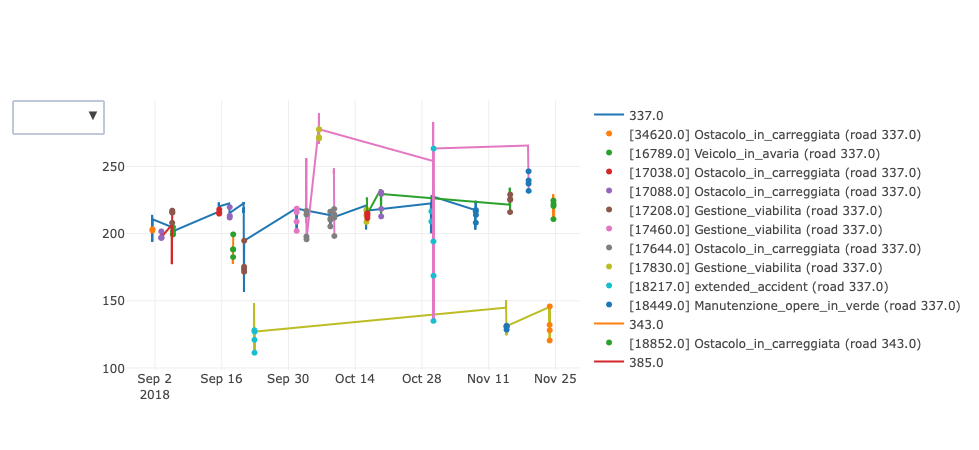

In [17]:
graph.show_speeds_with_events(tw_df, road_key=0, from_datetime='2010', to_datetime='2020')

In [42]:
# split the last m measure in different columns
def split_prediction_fields(row, event_beginning_step):
    return pd.Series((
            row.DATETIME_UTC[:event_beginning_step], row.DATETIME_UTC[event_beginning_step:], 
            row.SPEED_AVG[:event_beginning_step],    row.SPEED_AVG[event_beginning_step:],
            row.SPEED_SD[:event_beginning_step],     row.SPEED_SD[event_beginning_step:],
            row.SPEED_MAX[:event_beginning_step],    row.SPEED_MAX[event_beginning_step:],
            row.SPEED_MIN[:event_beginning_step],    row.SPEED_MIN[event_beginning_step:],
            row.N_VEHICLES[:event_beginning_step],   row.N_VEHICLES[event_beginning_step:]
    ))

In [43]:
joined_df[['DATETIME_UTC','DATETIME_UTC_y', 'SPEED_AVG','SPEED_AVG_Y', 'SPEED_SD','SPEED_SD_Y',
            'SPEED_MAX','SPEED_MAX_Y', 'SPEED_MIN','SPEED_MIN_Y',
            'N_VEHICLES', 'N_VEHICLES_Y']] = joined_df.apply(split_prediction_fields, axis=1, event_beginning_step=steps_behind_event)

In [45]:
#joined_df.head(15)
joined_df[joined_df.EVENT_TYPE.isnull()]

Empty DataFrame
Columns: [KEY, KM, event_index, DATETIME_UTC, SPEED_AVG, SPEED_SD, SPEED_MAX, SPEED_MIN, N_VEHICLES, EMERGENCY_LANE, LANES, ROAD_TYPE, EVENT_DETAIL, EVENT_TYPE, DATETIME_UTC_y, SPEED_AVG_Y, SPEED_SD_Y, SPEED_MAX_Y, SPEED_MIN_Y, N_VEHICLES_Y]
Index: []

In [46]:
for col_name in ['DATETIME_UTC','DATETIME_UTC_y', 'SPEED_AVG','SPEED_AVG_Y', 'SPEED_SD','SPEED_SD_Y',
                            'SPEED_MAX','SPEED_MAX_Y','SPEED_MIN','SPEED_MIN_Y', 'N_VEHICLES', 'N_VEHICLES_Y']:
    if col_name.upper().endswith('_Y'):
        new_cols = ['{}_{}'.format(col_name, i) for i in range(0, steps_after_event+1)]
    else:
        new_cols = ['{}_{}'.format(col_name, i) for i in range(-steps_behind_event, 0)]

    joined_df[new_cols] = pd.DataFrame(joined_df[col_name].values.tolist(), index=joined_df.index)

In [47]:
joined_df = joined_df.drop(['DATETIME_UTC','SPEED_AVG','SPEED_SD','SPEED_MAX','SPEED_MIN','N_VEHICLES',
                            'DATETIME_UTC_y','SPEED_AVG_Y','SPEED_SD_Y','SPEED_MAX_Y','SPEED_MIN_Y','N_VEHICLES_Y'], axis=1)

In [49]:
#joined_df
joined_df[joined_df.EVENT_TYPE.isnull()]

Empty DataFrame
Columns: [KEY, KM, event_index, EMERGENCY_LANE, LANES, ROAD_TYPE, EVENT_DETAIL, EVENT_TYPE, DATETIME_UTC_-10, DATETIME_UTC_-9, DATETIME_UTC_-8, DATETIME_UTC_-7, DATETIME_UTC_-6, DATETIME_UTC_-5, DATETIME_UTC_-4, DATETIME_UTC_-3, DATETIME_UTC_-2, DATETIME_UTC_-1, DATETIME_UTC_y_0, DATETIME_UTC_y_1, DATETIME_UTC_y_2, DATETIME_UTC_y_3, SPEED_AVG_-10, SPEED_AVG_-9, SPEED_AVG_-8, SPEED_AVG_-7, SPEED_AVG_-6, SPEED_AVG_-5, SPEED_AVG_-4, SPEED_AVG_-3, SPEED_AVG_-2, SPEED_AVG_-1, SPEED_AVG_Y_0, SPEED_AVG_Y_1, SPEED_AVG_Y_2, SPEED_AVG_Y_3, SPEED_SD_-10, SPEED_SD_-9, SPEED_SD_-8, SPEED_SD_-7, SPEED_SD_-6, SPEED_SD_-5, SPEED_SD_-4, SPEED_SD_-3, SPEED_SD_-2, SPEED_SD_-1, SPEED_SD_Y_0, SPEED_SD_Y_1, SPEED_SD_Y_2, SPEED_SD_Y_3, SPEED_MAX_-10, SPEED_MAX_-9, SPEED_MAX_-8, SPEED_MAX_-7, SPEED_MAX_-6, SPEED_MAX_-5, SPEED_MAX_-4, SPEED_MAX_-3, SPEED_MAX_-2, SPEED_MAX_-1, SPEED_MAX_Y_0, SPEED_MAX_Y_1, SPEED_MAX_Y_2, SPEED_MAX_Y_3, SPEED_MIN_-10, SPEED_MIN_-9, SPEED_MIN_-8, SPEED_MIN_-7, SPEED_MIN_-6, SPEED_MIN_-5, SPEED_MIN_-4, SPEED_MIN_-3, SPEED_MIN_-2, SPEED_MIN_-1, SPEED_MIN_Y_0, SPEED_MIN_Y_1, SPEED_MIN_Y_2, SPEED_MIN_Y_3, N_VEHICLES_-10, N_VEHICLES_-9, N_VEHICLES_-8, N_VEHICLES_-7, N_VEHICLES_-6, N_VEHICLES_-5, N_VEHICLES_-4, N_VEHICLES_-3, N_VEHICLES_-2, N_VEHICLES_-1, N_VEHICLES_Y_0, N_VEHICLES_Y_1, N_VEHICLES_Y_2, N_VEHICLES_Y_3]
Index: []

In [20]:
timewind[timewind.EVENT_TYPE.isnull()]

Empty DataFrame
Columns: [KEY, KM, event_index, DATETIME_UTC, SPEED_AVG, SPEED_SD, SPEED_MAX, SPEED_MIN, N_VEHICLES, EMERGENCY_LANE, LANES, ROAD_TYPE, EVENT_DETAIL, EVENT_TYPE, DATETIME_UTC_Y, SPEED_AVG_Y, SPEED_SD_Y, SPEED_MAX_Y, SPEED_MIN_Y, N_VEHICLES_Y, DATETIME_UTC_-10, DATETIME_UTC_-9, DATETIME_UTC_-8, DATETIME_UTC_-7, DATETIME_UTC_-6, DATETIME_UTC_-5, DATETIME_UTC_-4, DATETIME_UTC_-3, DATETIME_UTC_-2, DATETIME_UTC_-1, DATETIME_UTC_Y_0, DATETIME_UTC_Y_1, DATETIME_UTC_Y_2, DATETIME_UTC_Y_3, SPEED_AVG_-10, SPEED_AVG_-9, SPEED_AVG_-8, SPEED_AVG_-7, SPEED_AVG_-6, SPEED_AVG_-5, SPEED_AVG_-4, SPEED_AVG_-3, SPEED_AVG_-2, SPEED_AVG_-1, SPEED_AVG_Y_0, SPEED_AVG_Y_1, SPEED_AVG_Y_2, SPEED_AVG_Y_3, SPEED_SD_-10, SPEED_SD_-9, SPEED_SD_-8, SPEED_SD_-7, SPEED_SD_-6, SPEED_SD_-5, SPEED_SD_-4, SPEED_SD_-3, SPEED_SD_-2, SPEED_SD_-1, SPEED_SD_Y_0, SPEED_SD_Y_1, SPEED_SD_Y_2, SPEED_SD_Y_3, SPEED_MAX_-10, SPEED_MAX_-9, SPEED_MAX_-8, SPEED_MAX_-7, SPEED_MAX_-6, SPEED_MAX_-5, SPEED_MAX_-4, SPEED_MAX_-3, SPEED_MAX_-2, SPEED_MAX_-1, SPEED_MAX_Y_0, SPEED_MAX_Y_1, SPEED_MAX_Y_2, SPEED_MAX_Y_3, SPEED_MIN_-10, SPEED_MIN_-9, SPEED_MIN_-8, SPEED_MIN_-7, SPEED_MIN_-6, SPEED_MIN_-5, SPEED_MIN_-4, SPEED_MIN_-3, SPEED_MIN_-2, SPEED_MIN_-1, SPEED_MIN_Y_0, SPEED_MIN_Y_1, SPEED_MIN_Y_2, SPEED_MIN_Y_3, N_VEHICLES_-10, N_VEHICLES_-9, N_VEHICLES_-8, N_VEHICLES_-7, N_VEHICLES_-6, N_VEHICLES_-5, N_VEHICLES_-4, N_VEHICLES_-3, N_VEHICLES_-2, N_VEHICLES_-1, ...]
Index: []